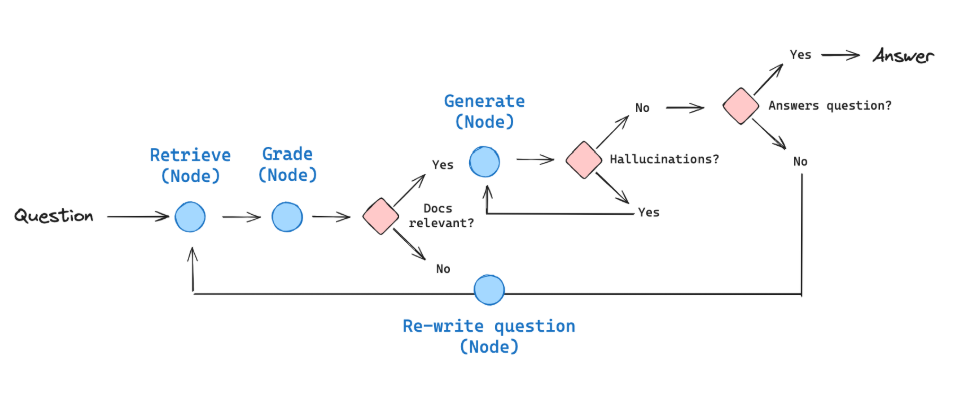

In [1]:
import os 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from typing import Literal, List
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from typing_extensions import TypedDict
from langchain.schema import Document
from langgraph.graph import END, StateGraph

USER_AGENT environment variable not set, consider setting it to identify your requests.
d:\miniconda3\envs\RAG\lib\site-packages\IPython\core\interactiveshell.py:3526: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# 设置环境变量
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '' # LangChain的API
os.environ['ZhiZengZeng_API_KEY'] = '' # 智增增的API，用来加载OpenAIEmbeddings
os.environ['DeepSeek_API_KEY'] = '' # DeepSeek的API，用来加载Chat模型

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, 
    chunk_overlap=0)

doc_splits = text_splitter.split_documents(docs_list)


embd = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    base_url="https://zhi-zeng-zeng.openai.com",
    api_key=os.environ['ZhiZengZeng_API_KEY']
)
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_metadata="rag-chroma",
    embedding=embd,
)

retriever = vectorstore.as_retriever()

([[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final re

In [8]:
# Data Model 
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_scores: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


In [ ]:
# 调用Deepseek的API
llm = ChatOpenAI(
    model="",
    base_url="",
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [ ]:
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)

In [ ]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content

In [ ]:
print("评分的结果", retrieval_grader.invoke({"question": question, 
                                            "document": doc_txt}))

In [ ]:
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(
    model="",
    base_url="",
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()

In [ ]:
generation = rag_chain.invoke({{"context": docs, 
                                "question": question}})
print("生成的结果", generation)

In [ ]:
# Data Model 
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_scores: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

llm = ChatOpenAI(
    model="",
    base_url="",
    temperature=0
)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
print("评分的结果", hallucination_grader.invoke({"documents": docs, 
                                                "generation":generation}))

In [ ]:
# Data Model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

llm = ChatOpenAI(
    model="",
    base_url="",
    temperature=0
)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader
print("评分的结果", answer_grader.invoke({"question": question, 
                                         "generation": generation}))

In [ ]:
### Question Re-writer

llm = ChatOpenAI(
    model="",
    base_url="",
    temperature=0
)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying sematic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print("重写的结果", question_rewriter.invoke({"question": question}))

In [ ]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents 
    """
    question: str
    generation: str
    documents: List[str]

In [ ]:
### Nodes
def retriever(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---Retriever---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents,
            "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---Generate---")
    question = state["question"]
    docs = state["documents"]

    # Generation
    generation = rag_chain.invoke({"context": docs, 
                                   "question": question})
    return {"documents": docs,
            "question": question,
            "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    docs = state["documents"]

    filtered_docs = []
    for d in docs:
        score = retrieval_grader.invoke({"question": question, 
                                         "document": d.page_content})
        grade = score.binary_scores
        if grade == "yes":
            print("Document is relevant")
            filtered_docs.append(d)
        else:
            print("Document is not relevant")
            continue
    return {"documents": filtered_docs, 
            "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    docs = state["documents"]

    better_question = question_rewriter.invoke({"question": question})
    return {"documents": docs,
            "question": better_question}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---DECIDE TO GENERATE---")
    filtered_docs = state["documents"]
    
    if not filtered_docs:
        print("No relevant documents found. Re-generating question.")
        return "transform_query"
    else:
        print("Relevant documents found. Generating answer.")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    docs = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": docs,
                                         "generation": generation})
    grade = score.binary_scores

    if grade == "yes":
        print("Generation is grounded in the document and answers question. Returning answer.")
        print("Grade Generation vs Documents and Question")
        score = answer_grader.invoke({"question": question, 
                                      "generation": generation})
        grade = score.binary_scores
        if grade == "yes":
            print("Generation answers the question.")
            return "useful"
        else:
            print("Generation does not answer the question.")
            return "not useful"
    else:
        print("Generation is not grounded in the document and does not answer the question. Re-generating question.")
        return "not supported"

In [ ]:
workflow = StateGraph(GraphState)
workflow.add_node("retriever", retriever)
workflow.add_node("generate", generate)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)

workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"transform_query": "transfrom_query", 
     "generate": generate},
)

workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END, 
        "not useful": "transform_query", 
        "not supported": "generate"
    },
)

app = workflow.compile()

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

In [ ]:
inputs = {"question": "Explain how chain of thought prompting works?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])